In [90]:
#Import dependencies
#Import data
#Preprocess for random forest model
#Scale data
#Bucket employment growth rate for prediction
#Instantiate, fit model, run predictions
#Measure accuracy

In [91]:
#Import dependencies
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from datetime import datetime
#import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#display options
pd.set_option ('display.max_rows', 10)
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import accuracy_score

In [92]:
#Set path of input file
file_path = "Resources/Cleaned_Data.csv"
#Read input file into a DataFrame
ratings_df = pd.read_csv(file_path)
ratings_df

,FIPS,State,County,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Smokers,...,% Not Proficient in English,% Female,% Rural,Employed 2015,Employed 2020,Employment Growth Rate,Primary Care Physicians Ratio,Dentist Ratio,Mental Health Provider Ratio,Other Primary Care Provider Ratio
0,1001,Alabama,Autauga,791.0,8129.0,21,4.7,4.7,9.0,18,...,1,51.4,42.0,23986.0,24580.0,2.476445,2220.0,3089.0,4277.0,2527.0
1,1003,Alabama,Baldwin,2967.0,7354.0,18,4.2,4.3,8.0,17,...,1,51.5,42.3,85953.0,98768.0,14.909311,1372.0,2019.0,1038.0,1787.0
2,1005,Alabama,Barbour,472.0,10254.0,30,5.4,5.2,11.0,22,...,2,47.2,67.8,8597.0,8707.0,1.279516,3159.0,2765.0,12441.0,1914.0
3,1007,Alabama,Bibb,471.0,11978.0,19,4.6,4.6,10.0,19,...,0,46.8,68.4,8294.0,8303.0,0.108512,2061.0,4480.0,4480.0,896.0
4,1009,Alabama,Blount,1085.0,11335.0,22,4.9,4.9,8.0,19,...,2,50.7,90.0,22189.0,22836.0,2.915859,4463.0,5258.0,6427.0,4449.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,Wyoming,Sweetwater,532.0,7832.0,15,3.4,3.6,10.0,18,...,2,48.5,10.9,23010.0,21572.0,-6.249457,2721.0,1872.0,395.0,1485.0
3138,56039,Wyoming,Teton,109.0,2731.0,12,3.0,3.2,8.0,15,...,4,48.4,46.4,14298.0,14909.0,4.273325,862.0,1154.0,210.0,923.0
3139,56041,Wyoming,Uinta,256.0,7331.0,16,3.6,3.7,10.0,17,...,1,49.3,43.1,10064.0,9710.0,-3.517488,2277.0,1128.0,282.0,1561.0
3140,56043,Wyoming,Washakie,110.0,6586.0,16,3.6,3.7,7.0,17,...,0,49.4,36.0,3892.0,3841.0,-1.310380,2016.0,1314.0,254.0,1971.0


In [93]:
#Bin employment growth rate to use for prediction
#Examine it again
ratings_df['Employment Growth Rate'].describe()

count    3142.000000
mean        2.965745
std         8.904445
min       -41.604676
25%        -1.962408
50%         2.700750
75%         7.456576
max       109.410007
Name: Employment Growth Rate, dtype: float64

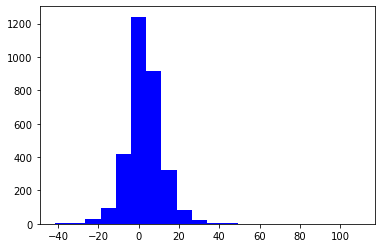

In [94]:
# Look at the distribution of values for employment growth rate
num_bins = 20
n,bins,patches = plt.hist(ratings_df['Employment Growth Rate'],num_bins, facecolor = 'blue')
plt.show()
#Looks fairly normal/bell shaped


In [95]:
#Make employment growth rate bands of 2.5%
#Create a function to calculate growth level and apply to column
def rate_bands(rate):
    max_band_threshold = 110
    band_size = 2.5
    max_band = int(max_band_threshold/band_size)
    if rate < max_band_threshold:
        rate_band = int(rate / band_size)
    else:
        rate_band = max_band
    return rate_band

In [96]:
ratings_df['Employment Growth Band'] = ratings_df['Employment Growth Rate'].apply(rate_bands)
ratings_df.head()

,FIPS,State,County,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Smokers,...,% Female,% Rural,Employed 2015,Employed 2020,Employment Growth Rate,Primary Care Physicians Ratio,Dentist Ratio,Mental Health Provider Ratio,Other Primary Care Provider Ratio,Employment Growth Band
0,1001,Alabama,Autauga,791.0,8129.0,21,4.7,4.7,9.0,18,...,51.4,42.0,23986.0,24580.0,2.476445,2220.0,3089.0,4277.0,2527.0,0
1,1003,Alabama,Baldwin,2967.0,7354.0,18,4.2,4.3,8.0,17,...,51.5,42.3,85953.0,98768.0,14.909311,1372.0,2019.0,1038.0,1787.0,5
2,1005,Alabama,Barbour,472.0,10254.0,30,5.4,5.2,11.0,22,...,47.2,67.8,8597.0,8707.0,1.279516,3159.0,2765.0,12441.0,1914.0,0
3,1007,Alabama,Bibb,471.0,11978.0,19,4.6,4.6,10.0,19,...,46.8,68.4,8294.0,8303.0,0.108512,2061.0,4480.0,4480.0,896.0,0
4,1009,Alabama,Blount,1085.0,11335.0,22,4.9,4.9,8.0,19,...,50.7,90.0,22189.0,22836.0,2.915859,4463.0,5258.0,6427.0,4449.0,1


In [97]:
pd.set_option ('display.max_rows', None)
ratings_df['Employment Growth Band'].value_counts()

 0     815
 1     476
 2     359
-1     276
 3     243
 4     175
-2     172
 5     136
-3     102
 6      77
 7      51
-4      51
 8      40
-6      33
-5      33
 9      19
-7      15
 10     13
-8      11
 12     10
-9       9
 11      6
 13      3
 18      2
-16      2
-11      2
 15      1
-14      1
 14      1
 43      1
 21      1
-10      1
 16      1
-15      1
-12      1
 22      1
 29      1
Name: Employment Growth Band, dtype: int64

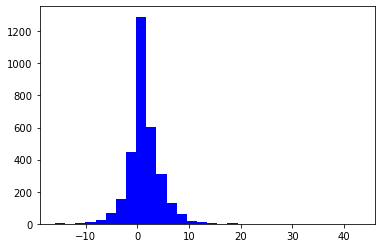

In [98]:
# 6. Look at the distribution of values for employment growth rate
num_bins = 30
n,bins,patches = plt.hist(ratings_df['Employment Growth Band'],num_bins, facecolor = 'blue')
plt.show()
#Looks fairly normal/bell shaped

In [99]:
#Throw all the lowest into their own bucket and all the highest into their own bucket to get rid of groups 
#with only one member which crashes the model
#So -10 and lower together and 12 and greater together
ratings_df['Employment Growth Band'] = np.where(ratings_df["Employment Growth Band"]>=12,12,ratings_df["Employment Growth Band"])
ratings_df['Employment Growth Band'] = np.where(ratings_df["Employment Growth Band"]<=-10,-10,ratings_df["Employment Growth Band"])

In [100]:
pd.set_option ('display.max_rows', None)
ratings_df['Employment Growth Band'].value_counts()

 0     815
 1     476
 2     359
-1     276
 3     243
 4     175
-2     172
 5     136
-3     102
 6      77
-4      51
 7      51
 8      40
-5      33
-6      33
 12     22
 9      19
-7      15
 10     13
-8      11
-9       9
-10      8
 11      6
Name: Employment Growth Band, dtype: int64

In [101]:
#inspect data to see which fields are strings that need to be converted to numeric
ratings_df.select_dtypes(include=['object']).columns

Index(['State', 'County'], dtype='object')

In [102]:
#State we can get_dummies for, and county is already represented by the FIPS code (which is the unique
#key which won't contribute information anyway) so it can be dropped
pd.set_option ('display.max_rows', 10)
preprocessed_df = ratings_df
preprocessed_df.drop(columns=['County'],inplace=True)
preprocessed_df

,FIPS,State,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Smokers,% Adults with Obesity,...,% Female,% Rural,Employed 2015,Employed 2020,Employment Growth Rate,Primary Care Physicians Ratio,Dentist Ratio,Mental Health Provider Ratio,Other Primary Care Provider Ratio,Employment Growth Band
0,1001,Alabama,791.0,8129.0,21,4.7,4.7,9.0,18,33,...,51.4,42.0,23986.0,24580.0,2.476445,2220.0,3089.0,4277.0,2527.0,0
1,1003,Alabama,2967.0,7354.0,18,4.2,4.3,8.0,17,31,...,51.5,42.3,85953.0,98768.0,14.909311,1372.0,2019.0,1038.0,1787.0,5
2,1005,Alabama,472.0,10254.0,30,5.4,5.2,11.0,22,42,...,47.2,67.8,8597.0,8707.0,1.279516,3159.0,2765.0,12441.0,1914.0,0
3,1007,Alabama,471.0,11978.0,19,4.6,4.6,10.0,19,38,...,46.8,68.4,8294.0,8303.0,0.108512,2061.0,4480.0,4480.0,896.0,0
4,1009,Alabama,1085.0,11335.0,22,4.9,4.9,8.0,19,34,...,50.7,90.0,22189.0,22836.0,2.915859,4463.0,5258.0,6427.0,4449.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,Wyoming,532.0,7832.0,15,3.4,3.6,10.0,18,30,...,48.5,10.9,23010.0,21572.0,-6.249457,2721.0,1872.0,395.0,1485.0,-2
3138,56039,Wyoming,109.0,2731.0,12,3.0,3.2,8.0,15,12,...,48.4,46.4,14298.0,14909.0,4.273325,862.0,1154.0,210.0,923.0,1
3139,56041,Wyoming,256.0,7331.0,16,3.6,3.7,10.0,17,36,...,49.3,43.1,10064.0,9710.0,-3.517488,2277.0,1128.0,282.0,1561.0,-1
3140,56043,Wyoming,110.0,6586.0,16,3.6,3.7,7.0,17,29,...,49.4,36.0,3892.0,3841.0,-1.310380,2016.0,1314.0,254.0,1971.0,0


In [103]:
#Get dummies for State field
df_binary_encoded = pd.get_dummies(preprocessed_df, columns=['State'])
df_binary_encoded.describe()

,FIPS,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Smokers,% Adults with Obesity,Food Environment Index,...,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
count,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,...,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,30383.649268,1334.757810,8582.946648,17.930617,3.990643,4.167696,8.146293,17.466900,32.901655,7.451361,...,0.021006,0.030236,0.080840,0.009230,0.004456,0.042330,0.012412,0.017505,0.022915,0.007320
std,15162.508374,3189.377652,2480.245236,4.746985,0.705693,0.602053,2.024920,3.626552,5.456978,1.141906,...,0.143426,0.171262,0.272633,0.095643,0.066613,0.201372,0.110735,0.131163,0.149657,0.085258
min,1001.000000,32.000000,2731.000000,8.000000,2.400000,2.500000,3.000000,6.000000,12.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18177.500000,245.000000,6910.500000,14.000000,3.500000,3.700000,7.000000,15.000000,29.000000,6.900000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29176.000000,547.000000,8582.946648,17.000000,3.900000,4.200000,8.000000,17.000000,33.000000,7.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,45080.500000,1334.757810,9917.250000,21.000000,4.400000,4.600000,9.000000,20.000000,37.000000,8.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,56045.000000,84296.000000,29138.000000,41.000000,7.100000,6.300000,24.000000,41.000000,58.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [104]:
#Write preprocessed data to a csv file to use in other models
df_binary_encoded.to_csv("Resources/Preprocessed_from_RF.csv",index=False)

In [105]:
#Set features and target values
#features
X = df_binary_encoded.drop(columns=['Employment Growth Rate','Employment Growth Band','FIPS','Employed 2020','Employed 2015'])
#target values
y = df_binary_encoded['Employment Growth Band']

In [106]:
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [107]:
from sklearn.metrics import accuracy_score
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.261


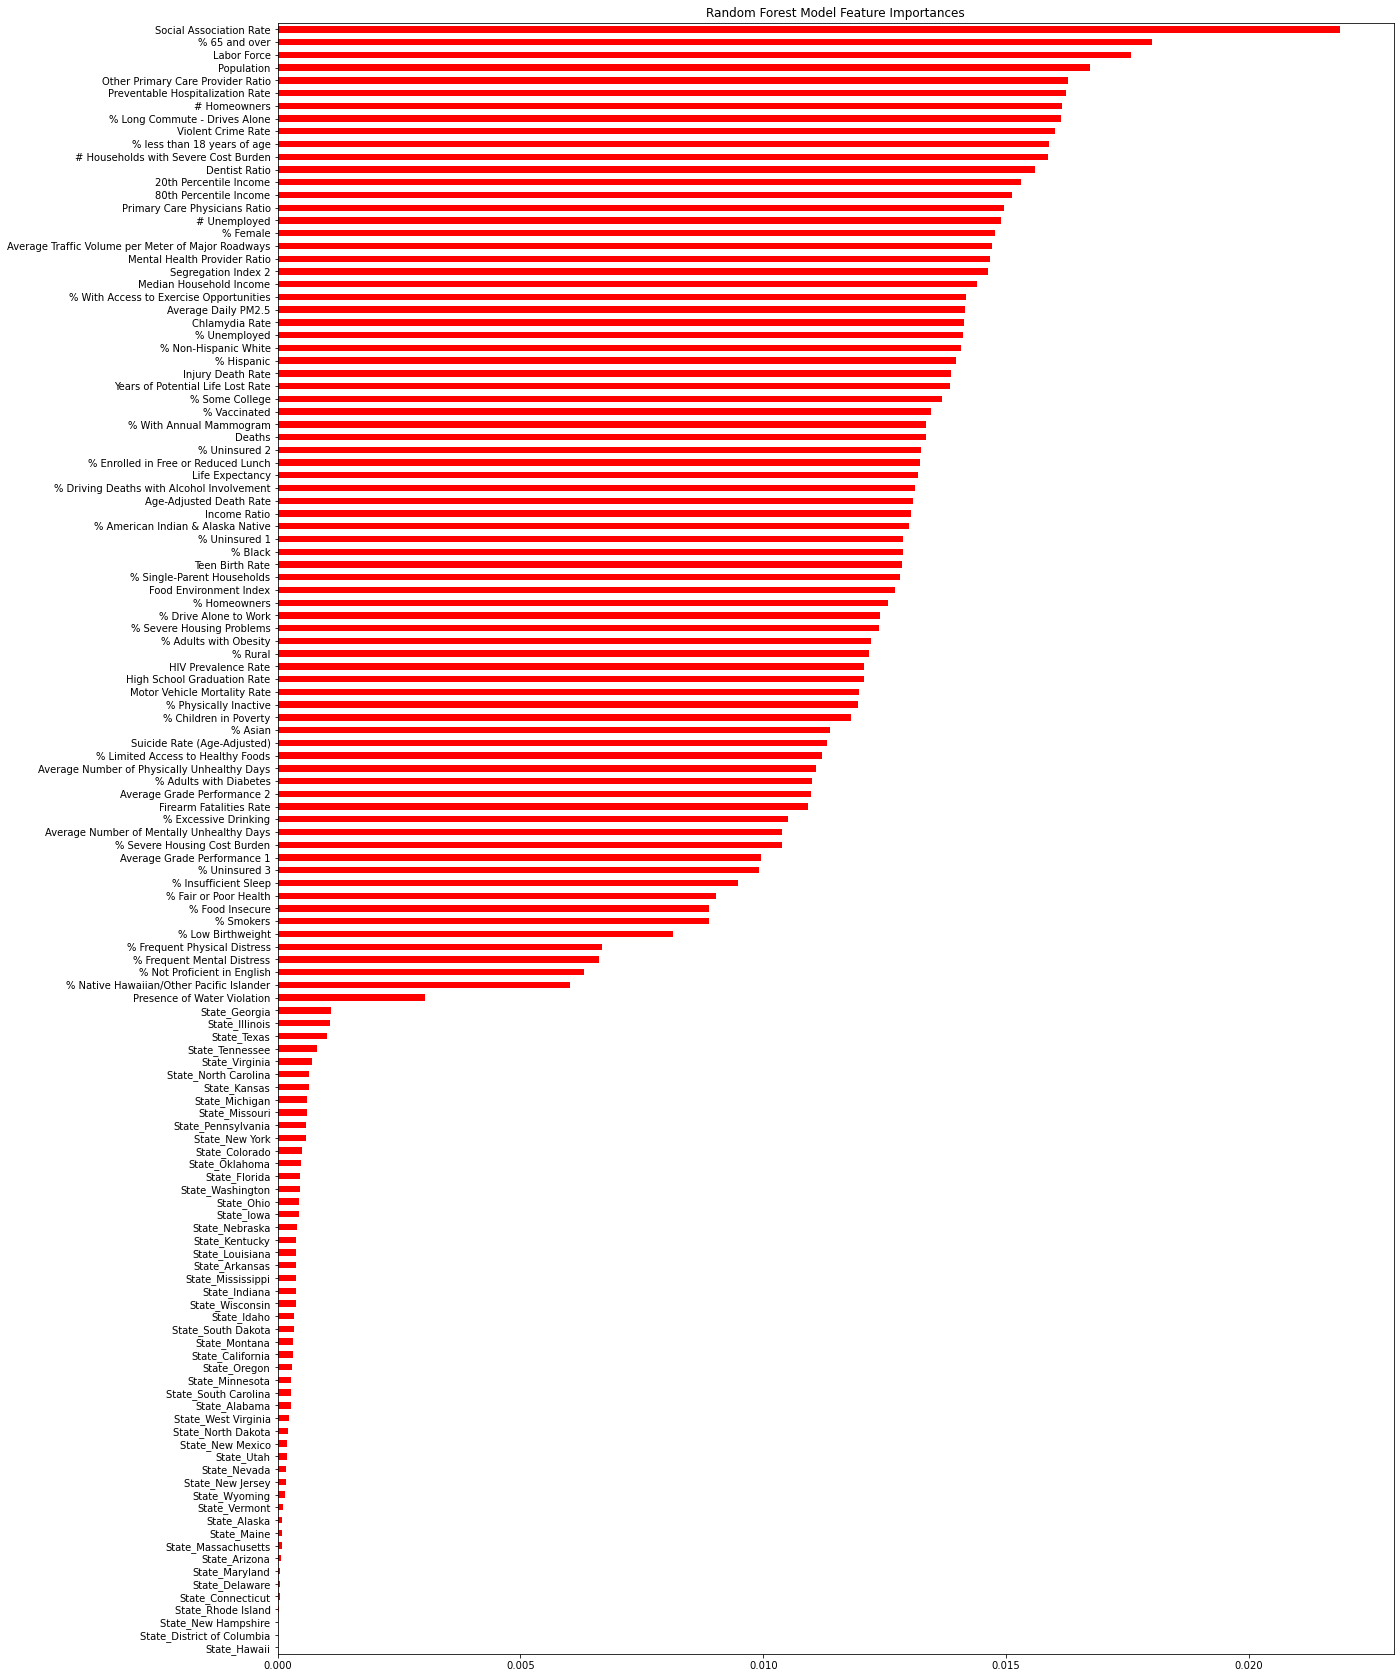

In [108]:
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_
importances
columns = X_train.columns
rfGraph = pd.Series(importances, columns)
from matplotlib.pyplot import figure
figure(figsize=(20,30))
rfGraph.sort_values().plot.barh(color="red")
plt.title("Random Forest Model Feature Importances")
plt.savefig("Resources/RF_Ranked_Importances.png")

In [109]:
columns_df = pd.DataFrame(columns,columns=['Feature'])
importances_df = pd.DataFrame(importances,columns=['Feature Importance'])
columns_df['Feature Importance']=importances_df["Feature Importance"]
columns_df

,Feature,Feature Importance
0,Deaths,0.013351
1,Years of Potential Life Lost Rate,0.013838
2,% Fair or Poor Health,0.009031
3,Average Number of Physically Unhealthy Days,0.011090
4,Average Number of Mentally Unhealthy Days,0.010387
...,...,...
123,State_Virginia,0.000712
124,State_Washington,0.000455
125,State_West Virginia,0.000228
126,State_Wisconsin,0.000370


In [110]:
import hvplot.pandas
columns_df.hvplot.table(columns=["Feature","Feature Importance"],sortable=True, selectable=True)

:Table   [Feature,Feature Importance]

In [111]:
# Resample the training data with the BalancedRandomForestClassifier

brf_model = BalancedRandomForestClassifier(n_estimators=100).fit(X_train,y_train)

In [112]:
# Calculated the balanced accuracy score - BalancedRandomForestClassifier
y_pred = brf_model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.18800934189599744

In [113]:
# Print the imbalanced classification report - BalancedRandomForestClassifier
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        -10       0.10      1.00      0.98      0.17      0.99      0.98         2
         -9       0.04      0.50      0.97      0.08      0.70      0.46         2
         -8       0.22      0.67      0.99      0.33      0.81      0.64         3
         -7       0.08      0.25      0.98      0.12      0.50      0.23         4
         -6       0.03      0.12      0.95      0.04      0.34      0.11         8
         -5       0.06      0.25      0.96      0.10      0.49      0.22         8
         -4       0.00      0.00      0.98      0.00      0.00      0.00        13
         -3       0.09      0.15      0.94      0.11      0.38      0.13        26
         -2       0.10      0.14      0.93      0.12      0.36      0.12        43
         -1       0.19      0.29      0.88      0.23      0.51      0.24        69
          0       0.55      0.12      0.97      0.19      0.34      0.10       204
   

In [116]:
#Add unsupervised class value to binary_encoded dataframe so we can run the RF models by class
#Set path of input file
file_path = "resources/Unsupervised_Cluster.csv"
#Read input file into a DataFrame
classes_df = pd.read_csv(file_path)
classes_df
class_number = classes_df[['FIPS','Class']]
class_number
df_binary_encoded = df_binary_encoded.merge(class_number,on=["FIPS",'FIPS'],how = 'left')
df_binary_encoded

,FIPS,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Smokers,% Adults with Obesity,Food Environment Index,...,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Class
0,1001,791.0,8129.0,21,4.7,4.7,9.0,18,33,7.2,...,0,0,0,0,0,0,0,0,0,4
1,1003,2967.0,7354.0,18,4.2,4.3,8.0,17,31,8.0,...,0,0,0,0,0,0,0,0,0,2
2,1005,472.0,10254.0,30,5.4,5.2,11.0,22,42,5.6,...,0,0,0,0,0,0,0,0,0,0
3,1007,471.0,11978.0,19,4.6,4.6,10.0,19,38,7.8,...,0,0,0,0,0,0,0,0,0,4
4,1009,1085.0,11335.0,22,4.9,4.9,8.0,19,34,8.4,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,532.0,7832.0,15,3.4,3.6,10.0,18,30,7.7,...,0,0,0,0,0,0,0,0,1,5
3138,56039,109.0,2731.0,12,3.0,3.2,8.0,15,12,8.2,...,0,0,0,0,0,0,0,0,1,5
3139,56041,256.0,7331.0,16,3.6,3.7,10.0,17,36,7.4,...,0,0,0,0,0,0,0,0,1,5
3140,56043,110.0,6586.0,16,3.6,3.7,7.0,17,29,8.3,...,0,0,0,0,0,0,0,0,1,2


In [117]:
df_binary_encoded['Class'].value_counts()

5    632
4    629
2    509
1    450
3    385
0    289
6    248
Name: Class, dtype: int64

In [62]:
#Create a function to run the random forest model

def rf_for_counties(df):
    #Set features and target values
    X = df.drop(columns=['Employment Growth Rate','Employment Growth Band','FIPS','Employed 2020','Employed 2015'])
    y = df['Employment Growth Band']
    # Split training/test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
    # Create a StandardScaler instance
    scaler = StandardScaler()
    # Fit the StandardScaler
    X_scaler = scaler.fit(X_train)
    # Scale the data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    # Create a random forest classifier.
    rf_model = RandomForestClassifier(n_estimators=128, random_state=78)
    # Fitting the model
    rf_model = rf_model.fit(X_train_scaled, y_train)
    # Evaluate the model
    y_pred = rf_model.predict(X_test_scaled)
    print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")
    accuracy = accuracy_score(y_test,y_pred)
    importances = rf_model.feature_importances_
    columns = X_train.columns
    columns_df = pd.DataFrame(columns,columns=['Feature'])
    importances_df = pd.DataFrame(importances,columns=['Feature Importance'])
    columns_df['Feature Importance']=importances_df["Feature Importance"]
    columns_df.sort_values(by=['Feature Importance'], inplace=True,ascending=False)
    return accuracy, columns_df

In [135]:
pd.set_option ('display.max_rows', 15)
all_accuracy,all_importances = rf_for_counties(df_binary_encoded)

 Random forest predictive accuracy: 0.267


In [136]:
all_importances

,Feature,Feature Importance
29,Social Association Rate,0.021250
63,% 65 and over,0.018587
22,Labor Force,0.017521
36,% Long Commute - Drives Alone,0.016686
76,Other Primary Care Provider Ratio,0.016098
...,...,...
116,State_Rhode Island,0.000047
98,State_Massachusetts,0.000037
88,State_Hawaii,0.000033
84,State_Delaware,0.000031


In [137]:
#Run random forest model for Good Job Growth >5%
good_df = df_binary_encoded.loc[df_binary_encoded["Employment Growth Rate"]>=5]
good_df
#df_binary_encoded['Employment Growth Rate']

,FIPS,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Smokers,% Adults with Obesity,Food Environment Index,...,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Class
1,1003,2967.0,7354.0,18,4.2,4.3,8.0,17,31,8.0,...,0,0,0,0,0,0,0,0,0,2
8,1017,654.0,11113.0,24,4.9,4.9,12.0,19,40,6.4,...,0,0,0,0,0,0,0,0,0,0
16,1033,1044.0,10645.0,21,4.6,4.6,10.0,19,31,7.4,...,0,0,0,0,0,0,0,0,0,4
17,1035,262.0,10822.0,29,5.4,5.4,14.0,21,43,5.6,...,0,0,0,0,0,0,0,0,0,0
18,1037,217.0,12691.0,25,5.1,5.1,14.0,20,40,6.9,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,55109,714.0,4659.0,10,3.0,3.1,5.0,14,28,9.2,...,0,0,0,0,0,0,0,1,0,5
3103,55111,769.0,6111.0,13,3.5,3.8,6.0,18,31,8.8,...,0,0,0,0,0,0,0,1,0,5
3104,55113,273.0,9721.0,16,4.0,4.2,6.0,20,36,7.8,...,0,0,0,0,0,0,0,1,0,5
3111,55127,1148.0,6099.0,14,3.5,3.6,6.0,15,29,8.3,...,0,0,0,0,0,0,0,1,0,5


In [138]:
good_accuracy,good_importances = rf_for_counties(good_df)

 Random forest predictive accuracy: 0.325


In [142]:
pd.set_option ('display.max_rows', 15)
good_importances.head(15)

,Feature,Feature Importance
29,Social Association Rate,0.021688
63,% 65 and over,0.018501
68,% Hispanic,0.018335
53,Segregation Index 2,0.016370
36,% Long Commute - Drives Alone,0.016348
73,Primary Care Physicians Ratio,0.015950
16,Preventable Hospitalization Rate,0.015763
13,Chlamydia Rate,0.015692
74,Dentist Ratio,0.015645
62,% less than 18 years of age,0.015629


In [140]:
#Run random forest model for High Job Growth >9%
high_df = df_binary_encoded.loc[df_binary_encoded["Employment Growth Rate"]>=9]
high_df

,FIPS,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Smokers,% Adults with Obesity,Food Environment Index,...,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Class
1,1003,2967.0,7354.0,18,4.2,4.3,8.0,17,31,8.0,...,0,0,0,0,0,0,0,0,0,2
16,1033,1044.0,10645.0,21,4.6,4.6,10.0,19,31,7.4,...,0,0,0,0,0,0,0,0,0,4
21,1043,1501.0,10182.0,22,4.7,4.9,8.0,18,37,8.2,...,0,0,0,0,0,0,0,0,0,4
40,1081,1701.0,6973.0,21,4.5,4.6,9.0,18,30,6.4,...,0,0,0,0,0,0,0,0,0,5
41,1083,1258.0,7722.0,20,4.5,4.8,9.0,18,34,8.1,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000,54017,126.0,7725.0,19,4.8,4.9,9.0,21,39,8.5,...,0,0,0,0,0,0,1,0,0,4
3018,54053,553.0,12577.0,25,5.6,5.5,9.0,24,41,7.3,...,0,0,0,0,0,0,1,0,0,4
3022,54061,989.0,6488.0,19,4.7,4.7,8.0,20,30,7.3,...,0,0,0,0,0,0,1,0,0,2
3024,54065,353.0,11740.0,21,5.0,5.0,9.0,21,41,8.1,...,0,0,0,0,0,0,1,0,0,3


In [141]:
high_accuracy,high_importances = rf_for_counties(high_df)

 Random forest predictive accuracy: 0.265


In [143]:
pd.set_option ('display.max_rows', 15)
high_importances.head(15)

,Feature,Feature Importance
73,Primary Care Physicians Ratio,0.020199
30,Violent Crime Rate,0.017638
62,% less than 18 years of age,0.017401
53,Segregation Index 2,0.017358
36,% Long Commute - Drives Alone,0.017302
76,Other Primary Care Provider Ratio,0.017118
71,% Female,0.017024
29,Social Association Rate,0.016845
74,Dentist Ratio,0.016212
57,# Homeowners,0.016180


In [144]:
#Run random forest model for counties with job losses
negative_df = df_binary_encoded.loc[df_binary_encoded["Employment Growth Rate"]<0]
negative_df

,FIPS,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Smokers,% Adults with Obesity,Food Environment Index,...,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Class
10,1021,829.0,10019.0,21,4.8,4.9,9.0,20,38,8.1,...,0,0,0,0,0,0,0,0,0,4
14,1029,305.0,11088.0,19,4.5,4.9,9.0,18,37,8.0,...,0,0,0,0,0,0,0,0,0,4
20,1041,290.0,9945.0,22,4.7,4.9,10.0,19,38,6.2,...,0,0,0,0,0,0,0,0,0,0
22,1045,859.0,10467.0,23,5.0,4.8,8.0,20,37,6.7,...,0,0,0,0,0,0,0,0,0,4
23,1047,918.0,14717.0,30,5.6,5.6,14.0,24,43,4.6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,56035,97.0,6080.0,12,3.0,3.1,8.0,14,30,8.5,...,0,0,0,0,0,0,0,0,1,5
3137,56037,532.0,7832.0,15,3.4,3.6,10.0,18,30,7.7,...,0,0,0,0,0,0,0,0,1,5
3139,56041,256.0,7331.0,16,3.6,3.7,10.0,17,36,7.4,...,0,0,0,0,0,0,0,0,1,5
3140,56043,110.0,6586.0,16,3.6,3.7,7.0,17,29,8.3,...,0,0,0,0,0,0,0,0,1,2


In [145]:
negative_accuracy,negative_importances = rf_for_counties(negative_df)

 Random forest predictive accuracy: 0.365


In [146]:
pd.set_option ('display.max_rows', 15)
negative_importances.head(15)

,Feature,Feature Importance
22,Labor Force,0.022411
57,# Homeowners,0.019223
21,# Unemployed,0.018829
61,Population,0.018542
59,# Households with Severe Cost Burden,0.018261
16,Preventable Hospitalization Rate,0.017969
32,Average Daily PM2.5,0.017033
76,Other Primary Care Provider Ratio,0.016816
29,Social Association Rate,0.016543
51,Median Household Income,0.016461


In [149]:
#Run random forest model for different classes
class_0 = df_binary_encoded.loc[df_binary_encoded["Class"]==0]
class_1 = df_binary_encoded.loc[df_binary_encoded["Class"]==1]
class_2 = df_binary_encoded.loc[df_binary_encoded["Class"]==2]
class_3 = df_binary_encoded.loc[df_binary_encoded["Class"]==3]
class_4 = df_binary_encoded.loc[df_binary_encoded["Class"]==4]
class_5 = df_binary_encoded.loc[df_binary_encoded["Class"]==5]
class_6 = df_binary_encoded.loc[df_binary_encoded["Class"]==6]
class_0_accuracy,class_0_importances = rf_for_counties(class_0)
class_1_accuracy,class_1_importances = rf_for_counties(class_1)
class_2_accuracy,class_2_importances = rf_for_counties(class_2)
class_3_accuracy,class_3_importances = rf_for_counties(class_3)
class_4_accuracy,class_4_importances = rf_for_counties(class_4)
class_5_accuracy,class_5_importances = rf_for_counties(class_5)
class_6_accuracy,class_6_importances = rf_for_counties(class_6)
pd.set_option ('display.max_rows', 15)
print(class_0_importances.head(15))
print(class_1_importances.head(15))
print(class_2_importances.head(15))
print(class_3_importances.head(15))
print(class_4_importances.head(15))
print(class_5_importances.head(15))
print(class_6_importances.head(15))

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.